# **ReadMe:**  
1. Download the pkl and csv files
2. Create a folder called ECSE551 on google drive
3. Upload the csv files in the folder
4. Go to the Runtime tab and click Run all

Mounted at /content/gdrive
Train image shape: (60000, 1, 28, 28)
Test image shape: (10000, 1, 28, 28)


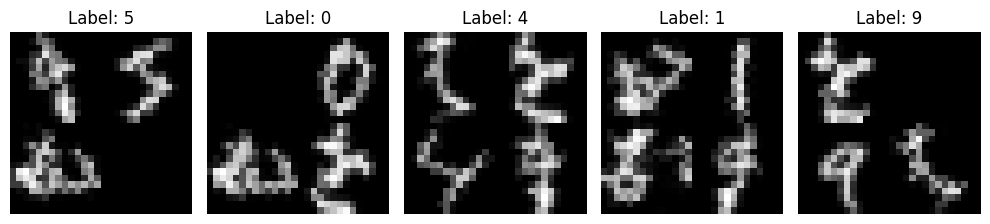

Computed mean: 0.00053310306975618, std: 0.000987895531579852


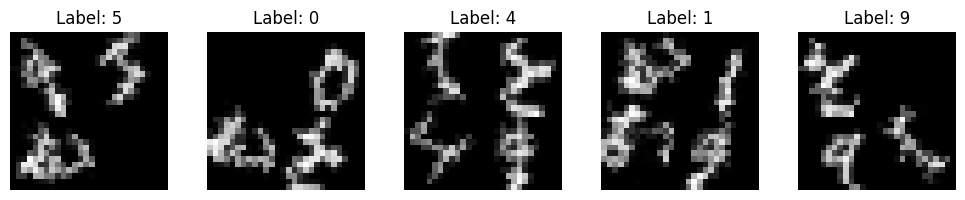

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from google.colab import drive

drive.mount('/content/gdrive')
with open('/content/gdrive/MyDrive/ECSE551/Train.pkl', 'rb') as f:
    train_images = pickle.load(f)
print("Train image shape:", train_images.shape)

with open('/content/gdrive/MyDrive/ECSE551/Test.pkl', 'rb') as f:
    test_images = pickle.load(f)
print("Test image shape:", test_images.shape)
label_df = pd.read_csv('/content/gdrive/MyDrive/ECSE551/Train_labels.csv', header=None)
train_labels = label_df[0].astype(int).values

def preview_samples(images, labels, n=5):
    plt.figure(figsize=(10, 4))
    for i in range(n):
        img = images[i, 0, :, :]
        lbl = labels[i]
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Label: {lbl}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

preview_samples(train_images, train_labels, n=5)

def compute_mean_std(images):
    all_imgs = images.astype(np.float32) / 255.0
    mean = np.mean(all_imgs)
    std = np.std(all_imgs)
    return mean, std

mean, std = compute_mean_std(train_images)
print(f"Computed mean: {mean}, std: {std}")

# mean = 0.5
# std = 0.5

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(15),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), shear=10),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

class DigitDataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx].squeeze(0)
        if self.transform:
            img = self.transform(img)
        if self.labels is not None:
            return img, self.labels[idx]
        else:
            return img

train_dataset = DigitDataset(train_images, train_labels, transform=train_transforms)
test_dataset = DigitDataset(test_images, transform=test_transforms)

def show_augmented_images(dataset, count=5):
    plt.figure(figsize=(10, 2))
    for i in range(count):
        img_tensor, label = dataset[i]
        img_np = img_tensor.permute(1, 2, 0).numpy()
        img_np = img_np * 0.5 + 0.5  # De-normalize
        plt.subplot(1, count, i + 1)
        plt.imshow(img_np, cmap='gray')
        plt.title(f'Label: {label}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_augmented_images(train_dataset)


In [ ]:
if torch.cuda.is_available():
    num_devices = torch.cuda.device_count()
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU detected: {gpu_name} ({num_devices} CUDA device(s))")
    compute_device = torch.device("cuda")
else:
    print("No GPU detected. Using CPU for training.")
    compute_device = torch.device("cpu")

device = compute_device


GPU detected: Tesla T4 (1 CUDA device(s))


In [ ]:
class CustomConvNet(nn.Module): # To improve CNN
    def __init__(self, num_classes):
        super(CustomConvNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),

            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2),
        )

        self.res_block = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=1),
            nn.ReLU()
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 256),
            # nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        out = self.conv_layers(x)
        shortcut = self.res_block(out)
        out = out + shortcut  # Residual connection
        return self.fc_layers(out)


def run_training(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss = 0
    for imgs, lbls in dataloader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = loss_fn(outputs, lbls)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def validate_model(model, dataloader, device):
    model.eval()
    correct_preds = 0
    total_samples = 0
    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            preds = model(imgs)
            _, predicted = torch.max(preds, 1)
            correct_preds += (predicted == lbls).sum().item()
            total_samples += lbls.size(0)
    return correct_preds / total_samples

def collect_predictions(model, dataloader, device):
    model.eval()
    preds_all = []
    labels_all = []
    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            preds = model(imgs)
            _, top_preds = torch.max(preds, 1)
            preds_all.extend(top_preds.cpu().numpy())
            labels_all.extend(lbls.cpu().numpy())
    return np.array(preds_all), np.array(labels_all)

class SmoothCrossEntropyLoss(nn.Module):
    def __init__(self, num_classes, smoothing=0.1):
        super(SmoothCrossEntropyLoss, self).__init__()
        self.num_classes = num_classes
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing

    def forward(self, predictions, targets):
        predictions = predictions.log_softmax(dim=-1)
        smoothed_targets = torch.zeros_like(predictions)
        smoothed_targets.fill_(self.smoothing / (self.num_classes - 1))
        smoothed_targets.scatter_(1, targets.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-smoothed_targets * predictions, dim=-1))


In [ ]:
from sklearn.model_selection import train_test_split

idx_train, idx_val = train_test_split(  # 80/20 split for training and validation
    np.arange(len(train_dataset)),
    test_size=0.2,
    shuffle=True,
    random_state=42
)

subset_train = Subset(train_dataset, idx_train)
subset_val = Subset(train_dataset, idx_val)

loader_train = DataLoader(subset_train, batch_size=64, shuffle=True)
loader_val = DataLoader(subset_val, batch_size=64)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(np.unique(train_labels))

model = CustomConvNet(num_classes=num_classes).to(device)

loss_fn = SmoothCrossEntropyLoss(num_classes=num_classes, smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', patience=3, factor=0.5
)

#Training Loop
val_scores = []

for ep in range(1, 31):  # 30 total epochs
    epoch_loss = run_training(model, loader_train, loss_fn, optimizer, device)
    epoch_val_acc = validate_model(model, loader_val, device)
    lr_scheduler.step(epoch_val_acc)

    print(f"[Epoch {ep:02}] , Loss: {epoch_loss:.4f} | Val Accuracy: {epoch_val_acc:.4f}")
    val_scores.append(epoch_val_acc)


[Epoch 01] , Loss: 1.2331 | Val Accuracy: 0.9043
[Epoch 02] , Loss: 0.7423 | Val Accuracy: 0.9408
[Epoch 03] , Loss: 0.6989 | Val Accuracy: 0.9473
[Epoch 04] , Loss: 0.6764 | Val Accuracy: 0.9515
[Epoch 05] , Loss: 0.6648 | Val Accuracy: 0.9563
[Epoch 06] , Loss: 0.6556 | Val Accuracy: 0.9621
[Epoch 07] , Loss: 0.6475 | Val Accuracy: 0.9548
[Epoch 08] , Loss: 0.6425 | Val Accuracy: 0.9626
[Epoch 09] , Loss: 0.6369 | Val Accuracy: 0.9550
[Epoch 10] , Loss: 0.6323 | Val Accuracy: 0.9663
[Epoch 11] , Loss: 0.6275 | Val Accuracy: 0.9676
[Epoch 12] , Loss: 0.6251 | Val Accuracy: 0.9657
[Epoch 13] , Loss: 0.6232 | Val Accuracy: 0.9671
[Epoch 14] , Loss: 0.6195 | Val Accuracy: 0.9636
[Epoch 15] , Loss: 0.6148 | Val Accuracy: 0.9672
[Epoch 16] , Loss: 0.5996 | Val Accuracy: 0.9694
[Epoch 17] , Loss: 0.5953 | Val Accuracy: 0.9728
[Epoch 18] , Loss: 0.5928 | Val Accuracy: 0.9725
[Epoch 19] , Loss: 0.5908 | Val Accuracy: 0.9680
[Epoch 20] , Loss: 0.5902 | Val Accuracy: 0.9729
[Epoch 21] , Loss: 0

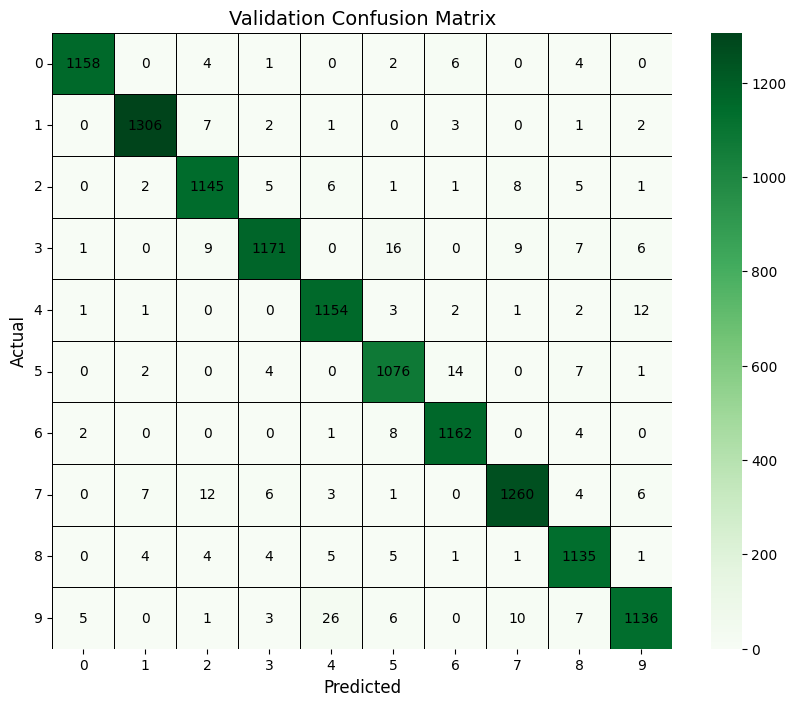

Validation Summary:
Validation Accuracies: [0.9043333333333333, 0.9408333333333333, 0.94725, 0.9515, 0.9563333333333334, 0.9620833333333333, 0.9548333333333333, 0.9625833333333333, 0.955, 0.9663333333333334, 0.9675833333333334, 0.96575, 0.9670833333333333, 0.9635833333333333, 0.9671666666666666, 0.9694166666666667, 0.97275, 0.9725, 0.968, 0.9729166666666667, 0.9725833333333334, 0.972, 0.9713333333333334, 0.9719166666666667, 0.97475, 0.9766666666666667, 0.975, 0.97625, 0.97475, 0.9756666666666667]
Mean Accuracy: 0.9643
Std Dev: 0.0143


In [ ]:
predicted_vals, actual_vals = collect_predictions(model, loader_val, device)

# Generate confusion matrix
conf_mat = confusion_matrix(actual_vals, predicted_vals)
plt.figure(figsize=(10, 8))
heat = sns.heatmap(
    conf_mat,
    cmap="Greens",
    cbar=True,
    fmt="d",
    linewidths=0.5,
    linecolor="black"
)

for row in range(conf_mat.shape[0]):
    for col in range(conf_mat.shape[1]):
        val = conf_mat[row, col]
        heat.text(
            col + 0.5,
            row + 0.5,
            str(val),
            ha="center",
            va="center",
            color="black",
            fontsize=10
        )

plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Validation Confusion Matrix", fontsize=14)

tick_labels = np.arange(conf_mat.shape[0])
plt.xticks(tick_labels + 0.5, tick_labels, fontsize=10)
plt.yticks(tick_labels + 0.5, tick_labels, fontsize=10, rotation=0)
plt.show()

# Print Results Summary
print("Validation Summary:")
print(f"Validation Accuracies: {val_scores}")
print(f"Mean Accuracy: {np.mean(val_scores):.4f}")
print(f"Std Dev: {np.std(val_scores):.4f}")


In [ ]:
train_all_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(np.unique(train_labels))
model = CustomConvNet(num_classes=num_classes).to(device)
loss_fn = SmoothCrossEntropyLoss(num_classes=num_classes, smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

def train_entire_model(model, dataloader, criterion, optimizer, scheduler, epochs=30):
    for ep in range(epochs):
        model.train()
        epoch_loss = 0
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            preds = model(x_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(dataloader)
        scheduler.step(avg_loss)
        print(f"[Epoch {ep+1:02}] Full Training Loss: {avg_loss:.4f}")

print("Starting full training")
train_entire_model(model, train_all_loader, loss_fn, optimizer, scheduler)

def run_inference(model, dataloader):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            logits = model(batch)
            _, top_classes = torch.max(logits, 1)
            all_preds.extend(top_classes.cpu().numpy())
    return np.array(all_preds)

print("Running inference on test data")
final_test_preds = run_inference(model, test_loader)


submission_df = pd.DataFrame({
    "id": np.arange(1, len(final_test_preds)+1),
    "class": final_test_preds.astype(int)
})
submission_df.to_csv("submission.csv", index=False)
print("Saved submission.csv (ready for Kaggle)")


Starting full training
[Epoch 01] Full Training Loss: 1.1244
[Epoch 02] Full Training Loss: 0.7204
[Epoch 03] Full Training Loss: 0.6830
[Epoch 04] Full Training Loss: 0.6629
[Epoch 05] Full Training Loss: 0.6545
[Epoch 06] Full Training Loss: 0.6276
[Epoch 07] Full Training Loss: 0.6215
[Epoch 08] Full Training Loss: 0.6185
[Epoch 09] Full Training Loss: 0.6165
[Epoch 10] Full Training Loss: 0.6019
[Epoch 11] Full Training Loss: 0.5991
[Epoch 12] Full Training Loss: 0.5987
[Epoch 13] Full Training Loss: 0.5953
[Epoch 14] Full Training Loss: 0.5902
[Epoch 15] Full Training Loss: 0.5881
[Epoch 16] Full Training Loss: 0.5860
[Epoch 17] Full Training Loss: 0.5852
[Epoch 18] Full Training Loss: 0.5835
[Epoch 19] Full Training Loss: 0.5820
[Epoch 20] Full Training Loss: 0.5805
[Epoch 21] Full Training Loss: 0.5797
[Epoch 22] Full Training Loss: 0.5790
[Epoch 23] Full Training Loss: 0.5781
[Epoch 24] Full Training Loss: 0.5767
[Epoch 25] Full Training Loss: 0.5775
[Epoch 26] Full Training Lo